# CarND Term 1: Advanced Lane Line Detection

In this notebook, I walk through a method for detecting lane lines from a video stream using common computer vision techniques. 



In [1]:
import numpy as np
import cv2
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Camera Calibration

The first step of our pipeline involves calculating the distortion of our camera images. To calculate the camera's distortion coefficients, we use an image with known measurements (in this case, a checkerboard pattern) and measure the difference between the two. 

First we define our "object points", which are the corners of the chessboard. `objp` is our array of coordinates that we'll measure our camera images against. In this case, it's a 6 x 9 chessboard.

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

Next, we load in the calibration images (photos of the chessboard taken by our camera) and use cv2's `findChessBoardCorners` function to detect the location of the corners in our image. 

Using the camera image corners and the "real-world" coordinates, we use cv2's `calibrateCamera` function to compute the distortion coefficient. It returns the root mean squared error of the calibration, the camera matrix, the distortion coefficients, rotation vectors, and translation vectors.

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if found == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Calculate distortion
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


This is what the original and undistorted images look like. 

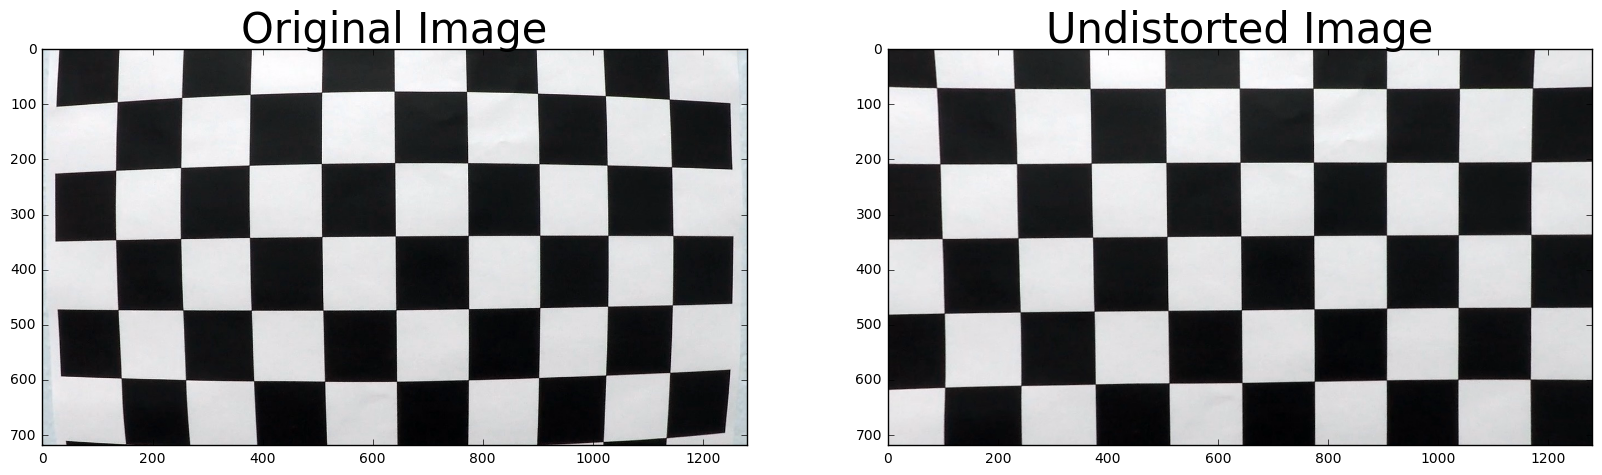

In [4]:
orig_img = cv2.imread(images[0])
## Undistort using coefficients calculated previously
new_img = cv2.undistort(orig_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(new_img)
ax2.set_title('Undistorted Image', fontsize=30)

## Single Image Pipeline

### Distortion correction
We apply this same distortion correction to our test images, as per the xample below. 


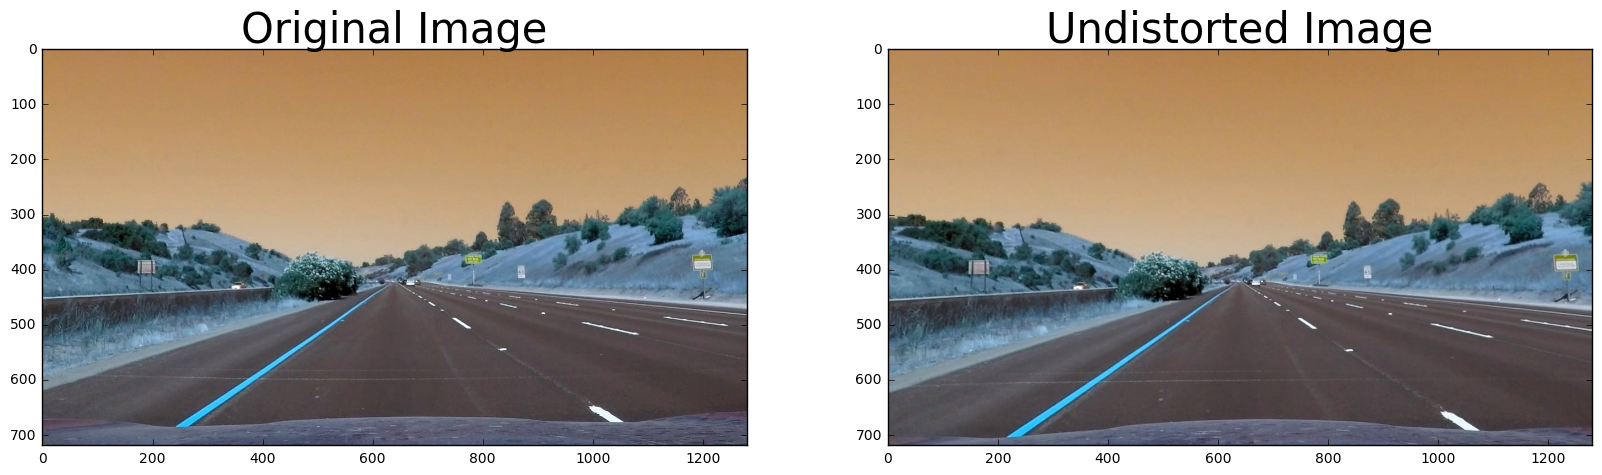

In [5]:
test_img = cv2.imread('test_images/straight_lines1.jpg')
test_img_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

### Gradient calculation

To transform our undistorted image into a binary image, I used the Sobel operator, which takes the gradient of each pixel in either the x or y direction. It appears that the Sobel operator in the x-axis did a better job of isolating the lane lines from other shapes in the image. 

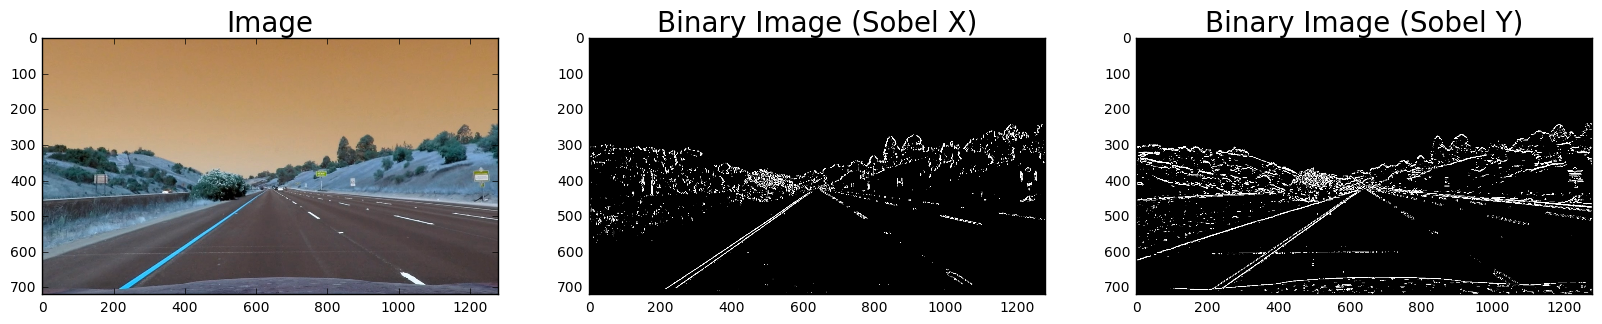

In [6]:
def abs_sobel_thresh(img, orient, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=="x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient=="y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise Exception("Orient must be x or y.")
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    

test_img_binx = abs_sobel_thresh(test_img_undist, "x", thresh_min=25, thresh_max=100)
test_img_biny = abs_sobel_thresh(test_img_undist, "y", thresh_min=25, thresh_max=100)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(test_img_undist)
ax1.set_title('Image', fontsize=20)
ax2.imshow(test_img_binx, cmap="gray")
ax2.set_title('Binary Image (Sobel X)', fontsize=20)
ax3.imshow(test_img_biny, cmap="gray")
ax3.set_title('Binary Image (Sobel Y)', fontsize=20)

### Perspective Transform

In the next step of the process, we apply a perspective transform in order to get a birds-eye view of the road ahead. I used hard-coded coordinates to construct the transformation. 

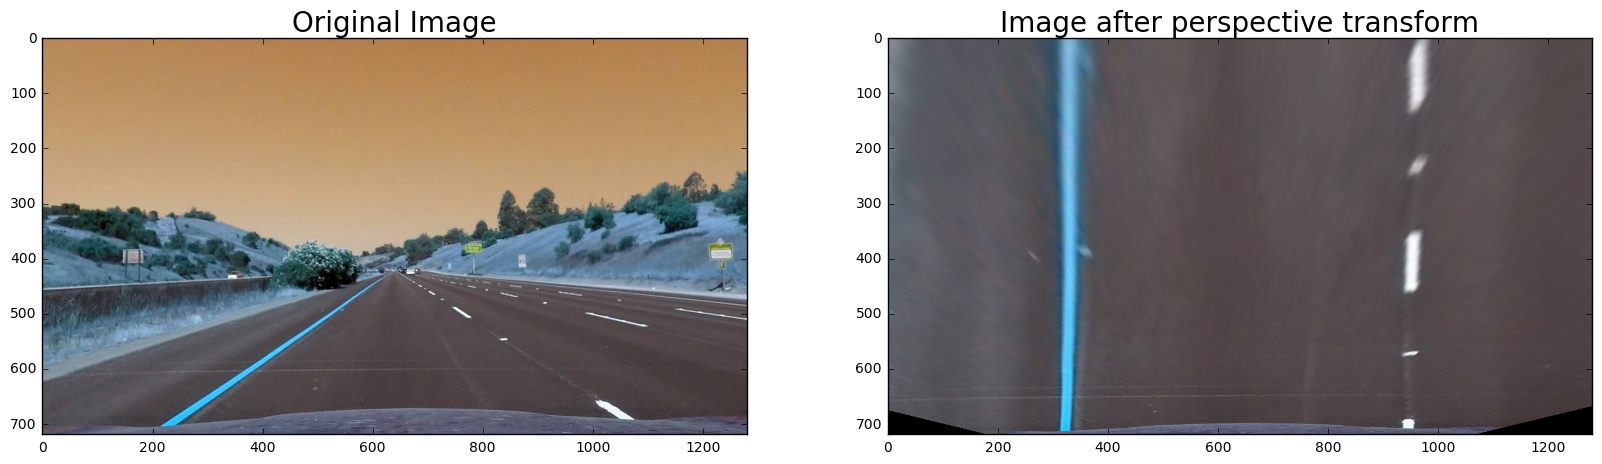

In [7]:
# Define the coordinates of a region in our source image
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

# Define the corresponding coordinates of our target image
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)

transform_M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, transform_M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Image after perspective transform', fontsize=20)

Combining the steps demonstrated above gives us the image processing pipeline necessary for drawing the lane regions of the image. 

1. Camera undistortion
2. Gradient thresholding with Sobel
3. Perspective transform

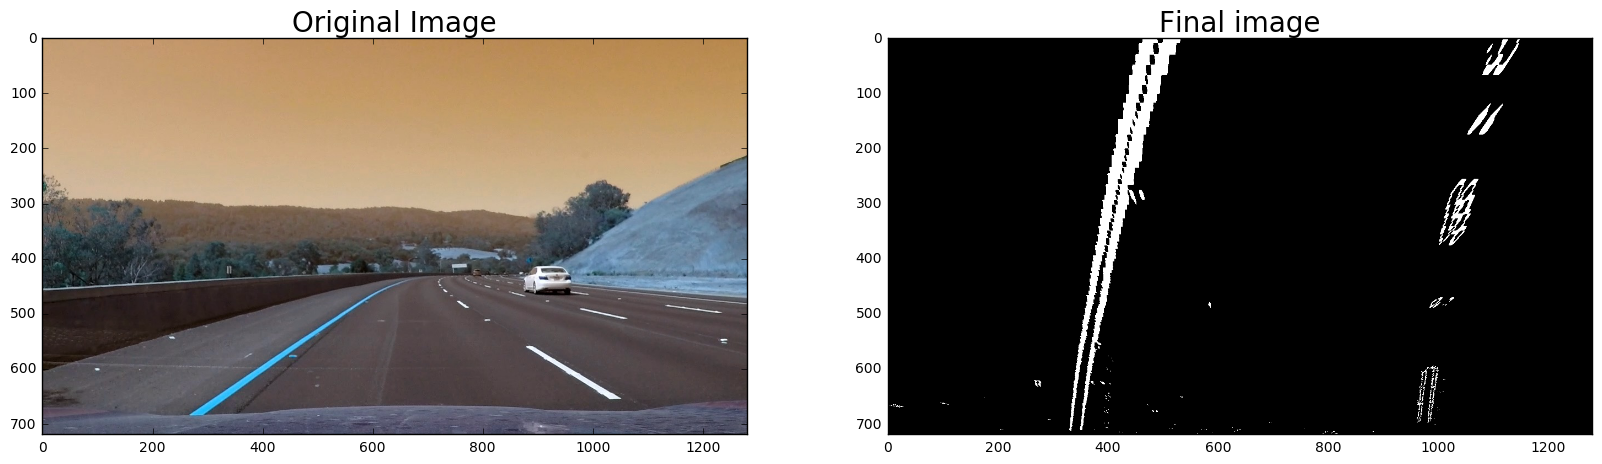

In [8]:
img = cv2.imread('test_images/test3.jpg')

def transform_image(img, camera_mtx, camera_dist, perspective_mtx, s_thresh=(0, 255)):
    ## Get image size in length by height
    img_size = (img.shape[1], img.shape[0])
    
    ## Camera distortion correction
    img = cv2.undistort(img, camera_mtx, camera_dist, None, camera_mtx)
    
    ## Sobel operator
    img = abs_sobel_thresh(img, "x", s_thresh[0], s_thresh[1])
    
    ## Perspective transform
    img = cv2.warpPerspective(img, perspective_mtx, img_size, flags=cv2.INTER_LINEAR)
    
    return img

warped = transform_image(img, mtx, dist, transform_M, (25, 100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped, cmap="gray")
ax2.set_title('Final image', fontsize=20)

### Lane Detection

Next we detect the presence of lane lines in our transformed, thresholded image. To do this we first find the base of our line by summing up the non-zero pixels height-wise from the bottom half of the image and finding the peaks. 

Left lane line starts at:  381
Right lane line starts at:  989


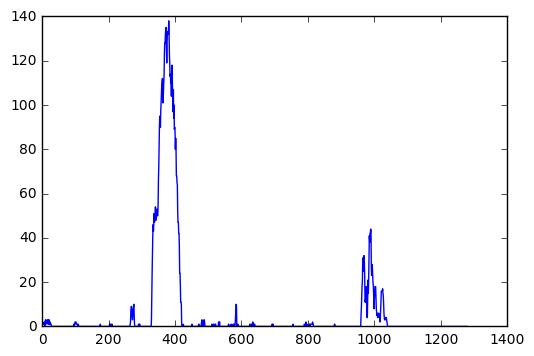

In [9]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

def get_line_base(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    return leftx_base, rightx_base    
        
leftx_base, rightx_base = get_line_base(warped)

print ("Left lane line starts at: ", leftx_base)
print ("Right lane line starts at: ", rightx_base)

We use the bases of the lines to narrow our search over the rest of the image. We first divide the image into horizontal sections. For each lane line, we iterate through each section starting from the bottom, using the previously detected lane midpoint to draw a window over which we select the non-zero pixels for the lane line (if there aren't enough non-zero pixels in the window in question, it draws the next window around the previously determined x coordinate). 

This is all implemented in the `sliding_window_search` function. 


In [10]:
def sliding_window_search(nonzerox, nonzeroy, x_start, window_height, nwindows, margin=50, minpix=50):
    
    x_current=x_start
    
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
        # Append these indices to the lists
        lane_inds.append(good_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))
    
    lane_inds = np.concatenate(lane_inds)
    return lane_inds

## Get x and y coordinates of non-zero pixels
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

## Get height of the windows used for the sliding window search
nwindows = 9
window_height = np.int(warped.shape[0]//nwindows)

left_lane_inds = sliding_window_search(nonzerox, nonzeroy, leftx_base, window_height, nwindows, margin=50, minpix=50)
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 

right_lane_inds = sliding_window_search(nonzerox, nonzeroy, rightx_base, window_height, nwindows, margin=50, minpix=50)
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

Next, we use numpy's `polyfit` function to fit a 2nd-degree polynomial curve using our detected left lane pixels and right lane pixels.

(720, 0)

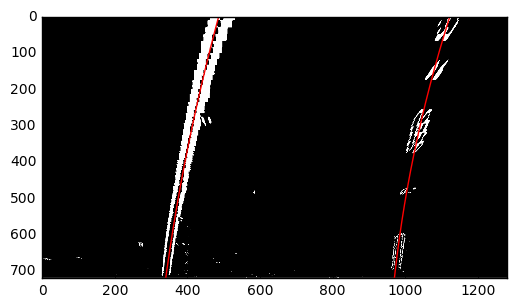

In [11]:

def calculate_current_fit(x_pixels, y_pixels, height):
    fit =  np.polyfit(y_pixels, x_pixels, 2)
    yfitted = np.linspace(0, height-1, num=height)
    xfitted = fit[0]*yfitted**2 + fit[1]*yfitted + fit[2] 
    return xfitted, yfitted

leftx, lefty = calculate_current_fit(leftx, lefty, warped.shape[0])
rightx, righty = calculate_current_fit(rightx, righty, warped.shape[0])

plt.imshow(warped, cmap="gray")
plt.plot(leftx, lefty, color='red')
plt.plot(rightx, righty, color='red')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0], 0)

To calculate curvature, we use the following equation: 

<img src="examples/Curvature.png">

where A and B are the coefficients on the second- and first-degree terms of our polynomial fit. To calculate the curvature in real-life units, I convert from pixel space to meters in the y and x dimensions with the parameters `ym_per_pix` (meters per y pixel) and `xm_per_pix` (meters per x pixel). 

To calculate the relative position of the car, we convert the x-axis from pixels to meters, get the position of the center of the lane by averaging the base of the right and left lines, and subtract it from the midpoint of the camera image (which we assume to be positioned at the center of the car). 



In [14]:
def calculate_radius(x_val, y_val, 
                     ym_per_pix = 30./720, 
                     xm_per_pix = 3.7/700):
    y_eval = np.max(y_val)
    fit_cr = np.polyfit(y_val*ym_per_pix, x_val*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return curverad


Finally, we shade in the region between our detected lane lines and draw the detected lane region back onto the original image in the `draw_lane` function.

`process_frame` contains the full pipeline for transforming and detecting the lanes in a given image. 

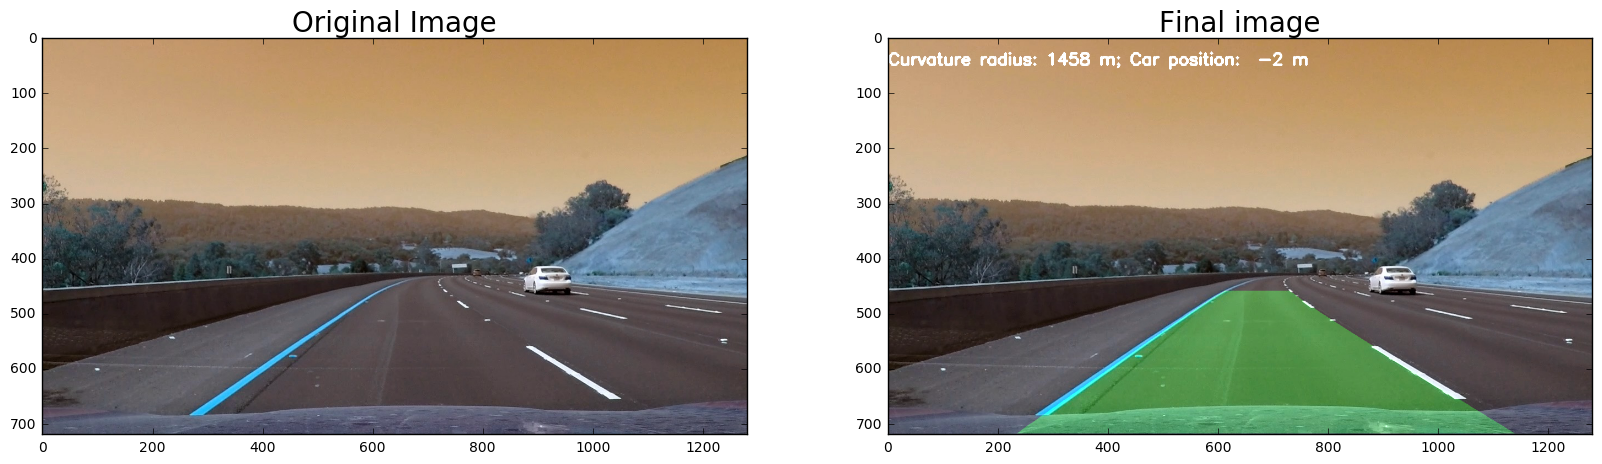

In [54]:
def draw_lane(warped, lline_x, lline_y, rline_x, rline_y, Minv, img_shape):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lline_x, lline_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rline_x, rline_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[0], img_shape[1])) 
    return newwarp


def process_frame(img, mtx, dist, transform_M, s_thresh, nwindows=9):
    
    warped = transform_image(img, mtx, dist, transform_M, s_thresh)
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    window_height = np.int(warped.shape[0]//nwindows)

    left_lane_inds = sliding_window_search(nonzerox, nonzeroy, leftx_base, window_height, nwindows, margin=50, minpix=50)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 

    right_lane_inds = sliding_window_search(nonzerox, nonzeroy, rightx_base, window_height, nwindows, margin=50, minpix=50)
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    leftx, lefty = calculate_current_fit(leftx, lefty, warped.shape[0])
    rightx, righty = calculate_current_fit(rightx, righty, warped.shape[0])
    
    lane = draw_lane(warped, leftx, lefty, rightx, righty, np.linalg.inv(transform_M), (img.shape[1], img.shape[0]))
    
    final_img = cv2.addWeighted(img, 1, lane, 0.3, 0)
    
    lrad = calculate_radius(leftx, lefty)
    rrad = calculate_radius(rightx, righty)
    
    ## Get road curvature and car position
    curve =  (lrad + rrad)/2
    lane_center_pos = (leftx[-1] + rightx[-1])/2 * 3.7/700
    car_center_pos = (img.shape[0]/2)*3.7/700
    car_relative_pos = car_center_pos - lane_center_pos
    info_text = "Curvature radius: {0} m; Car position: {1} m".format(("%3.f" % curve), ("%3.f" % car_relative_pos))
    
    final_img = cv2.putText(final_img, info_text, (0,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    
    return final_img

final = process_frame(img, mtx, dist, transform_M, (25, 100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(final, cmap="gray")
ax2.set_title('Final image', fontsize=20)

### Video Pipeline

When applying our image processing pipeline to consecutive frames from a video stream, I added several enhacements. 

- Improved lane pixel search: Instead of detecting the base of the line and using the sliding window search technique for each frame, we use the previously detected line (if it exists) to define a window around which to detect lane pixels in the current frame. 


In [25]:
def last_line_search(fit, nonzerox, nonzeroy, margin=100):

    lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) 
                 & (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin))) 

    return lane_inds


We define a class called `Line` that contains the other changes: 

- Sanity check: Check results from each frame and if they fall outside certain acceptable thresholds, carry forward the previously detected frame. This is the `calculate_current_fit` method.
- Smoothing: We average the fitted lane lines from the last N frames to avoid jumpy lane regions in our output video. This is the `get_smoothed_fit` method.

In [40]:
class Line(object):
    def __init__(self, ylen, linetype, memory):
        ## Right or left
        self.linetype = linetype
        # was the line detected in the last iteration?
        self.detected = False 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # x values of current x fit 
        self.current_xfitted = None
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        ## Y coordinates
        self.ploty = np.linspace(0, ylen-1, num=ylen)
        
        ## Number of previous fits to apply smoothing over
        self.memory = memory
        
    def detect_line(self, img, nwindows):
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        window_height = np.int(warped.shape[0]//nwindows)
        
        if self.detected == False:
            if self.linetype=="left":
                line_base, _ = get_line_base(img)
            else:
                _, line_base = get_line_base(img)
            lane_inds = sliding_window_search(nonzerox, nonzeroy, line_base, window_height, nwindows, margin=50, minpix=50)
        else: 
            lane_inds = last_line_search(self.best_fit, nonzerox, nonzeroy)
        
        self.allx = nonzerox[lane_inds]
        self.ally = nonzeroy[lane_inds] 
        
        if self.allx.size == 0 or self.ally.size == 0:
            self.detected=False
        else:
            self.detected=True
            self.calculate_current_fit()
        
        self.get_smoothed_fit()
        return
        
    def calculate_current_fit(self):
        fit =  np.polyfit(self.ally, self.allx, 2)
        
        ## Check if curvature radius is within 500 meters of the previous frame. 
        rad = calculate_radius(fit[0]*self.ploty**2 + fit[1]*self.ploty + fit[2], self.ploty)
        if self.radius_of_curvature is not None and abs(rad - self.radius_of_curvature) > 500:
            self.detected=False
            self.radius_of_curvature = rad
            return
        
        ## Check if position of the line is within 2 meters of the previous frame
        
        line_base_pos = (fit[0]*self.ploty[-1]**2 + fit[1]*self.ploty[-1] + fit[2])* 3.7/700
        if self.line_base_pos is not None and abs(line_base_pos - self.line_base_pos) > .25 :
            self.detected=False
            return
        
        self.current_fit = fit
        self.current_xfitted = fit[0]*self.ploty**2 + fit[1]*self.ploty + fit[2] 
        return
    
    def get_smoothed_fit(self):
        if self.detected:
            self.recent_xfitted.append(self.current_xfitted)
        else:
            self.recent_xfitted += self.recent_xfitted[-1:]
        self.recent_xfitted = self.recent_xfitted[-self.memory:]
        if len(self.recent_xfitted)>0:
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            self.best_fit = np.polyfit(self.ploty, self.bestx, 2)
            self.line_base_pos = self.bestx[-1] * 3.7/700
            self.radius_of_curvature = calculate_radius(self.best_fit[0]*self.ploty**2 + self.best_fit[1]*self.ploty + self.best_fit[2], self.ploty)
        return

Finally we wrap our entire pipeline in a FrameProcessor object that contains two `Line` objects for the right and left lane lines, and performs the image transformation, lane detection, and sanity checking/smoothing discussed above.  

In [51]:
class FrameProcessor(object):
    
    def __init__(self, mtx, dist, transform_M, img_shape, nwindows=9, memory=5):
        self.lline = Line(img_shape[0], "left", memory)
        self.rline = Line(img_shape[0], "right", memory)
        self.mtx = mtx
        self.dist = dist
        self.M = transform_M
        self.Minv = np.linalg.inv(transform_M)
        self.img_shape = img_shape
        self.nwindows = nwindows
        
    def get_lane_info(self):
        curve =  (self.lline.radius_of_curvature + self.rline.radius_of_curvature)/2
        lane_center_pos = (self.lline.line_base_pos + self.rline.line_base_pos)/2
        car_center_pos = (self.img_shape[1]/2)*3.7/700
        car_relative_pos = car_center_pos - lane_center_pos
        text = "Curvature radius: {0} m; Car position: {1} m".format(("%3.f" % curve), ("%3.f" % car_relative_pos))
        return text

    def process_frame(self, img, s_thresh=(25, 100)):

        warped = transform_image(img, self.mtx, self.dist, self.M, s_thresh)
        
        self.lline.detect_line(warped, self.nwindows)
        self.rline.detect_line(warped, self.nwindows)

        lane = draw_lane(warped, self.lline.bestx, self.lline.ploty, self.rline.bestx, self.rline.ploty, np.linalg.inv(transform_M), (img.shape[1], img.shape[0]))

        final_img = cv2.addWeighted(img, 1, lane, 0.3, 0)

        info_text = self.get_lane_info()

        final_img = cv2.putText(final_img, info_text, (0,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

        return final_img
    

Let's look at the final video output.

In [52]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output="test.mp4"
orig_clip = VideoFileClip('project_video.mp4')

frameProcessor = FrameProcessor(mtx, dist, transform_M, (img.shape[1], img.shape[0]), 5)

lane_clip = orig_clip.fl_image(frameProcessor.process_frame)
lane_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [05:05<00:00,  5.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Discussion

A few ideas to make the pipeline more robust: 
- Autodetection of the perspective transform: this will be necessary if the camera is ever moved from its original position. 
- Trying different color channels. I noticed that the lane detection tends to fail when the lighting changes (from light to shade, for example).